# Multimodal Retrieval from Vector Stores

## Setup

In [3]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
import os

### Setup vectorstore

In [5]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "your-key")

In [6]:
embeddings = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))
vectorstore = Chroma(
    persist_directory="./chroma_db",      
    embedding_function=embeddings,
    collection_name="test_tbl"            
)

/var/folders/9k/d309s7c57k58fd3w2q9mnq6m0000gn/T/ipykernel_32430/1700431657.py:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))
/var/folders/9k/d309s7c57k58fd3w2q9mnq6m0000gn/T/ipykernel_32430/1700431657.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [7]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

### Prepare Data

In [13]:
def load_json_file(path: str):
    """
    Load JSON content from a file and return as Python object.
    """
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

In [4]:
# for video1, we pick n = 7
n = 7
updated_vid1_trans = [
 ' '.join(vid1_trans[i-int(n/2) : i+int(n/2)]) if i-int(n/2) >= 0 else
 ' '.join(vid1_trans[0 : i + int(n/2)]) for i in range(len(vid1_trans))
]

# also need to update the updated transcripts in metadata
for i in range(len(updated_vid1_trans)):
    vid1_metadata[i]['transcript'] = updated_vid1_trans[i]

In [5]:
print(f'A transcript example before update:\n"{vid1_trans[6]}"')
print()
print(f'After update:\n"{updated_vid1_trans[6]}"')

A transcript example before update:
"spacewalk and to now have the chance to have done"

After update:
"two months. The view is always amazing I didn't think I would do another spacewalk and to now have the chance to have done four more was just icing on the cake for a a wonderful mission."


In [18]:
# %% Cell X: Update Vid1 Transcripts & Index into Chroma
import json
from pathlib import Path
from langchain.schema import Document

# Path to vid1 metadata JSON
vid1_metadata_path = './shared_data/videos/video1/metadatas.json'

# Load metadata list
vid1_metadata = load_json_file(vid1_metadata_path)

# Update transcripts using a sliding window of size n=7
n = 7
original_transcripts = [item['transcript'] for item in vid1_metadata]
updated_transcripts = []
for i in range(len(original_transcripts)):
    start = max(0, i - n // 2)
    end = min(len(original_transcripts), i + n // 2 + 1)
    updated_transcripts.append(' '.join(original_transcripts[start:end]))

# Apply updated transcripts back to metadata entries
for idx, transcript in enumerate(updated_transcripts):
    vid1_metadata[idx]['transcript'] = transcript

# (Optional) Save updated metadata to a new JSON file
updated_meta_path = './shared_data/videos/video1/metadatas_updated.json'
with open(updated_meta_path, 'w', encoding='utf-8') as f:
    json.dump(vid1_metadata, f, indent=2)

# Create Document objects for Chroma indexing
# Use only vid1 metadata since working on video1
docs = []
for meta in vid1_metadata:
    docs.append(Document(
        page_content=meta['transcript'],
        metadata={
            'video_path':       meta.get('video_path'),
            'extracted_frame':  meta.get('extracted_frame_path'),
            'mid_time_ms':      meta.get('mid_time_ms')
        }
    ))

# Add documents to Chroma vector store and persist
vectorstore.add_documents(docs)
vectorstore.persist()

print(f"Indexed {len(docs)} documents for video1 with updated transcripts.")


Indexed 26 documents for video1 with updated transcripts.


In [20]:
# Initialize OpenAI embedder
embedder = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

# Recreate vectorstore for overwrite mode
vectorstore = Chroma(
    persist_directory="./shared_data/chroma_db",
    embedding_function=embedder,
    collection_name="test_tbl"
)

# Prepare documents for both videos
all_meta = vid1_metadata 
all_docs = []
for meta in all_meta:
    all_docs.append(Document(
        page_content=meta['transcript'],
        metadata={
            'video_path':      meta.get('video_path'),
            'extracted_frame': meta.get('extracted_frame_path'),
            'mid_time_ms':     meta.get('mid_time_ms')
        }
    ))

# Add and persist all documents in overwrite mode
vectorstore.add_documents(all_docs)
vectorstore.persist()

print(f"Re-indexed {len(all_docs)} total documents into Chroma.")

Re-indexed 26 total documents into Chroma.


### Create Connection to a Table in Chroma

In [22]:
import pandas as pd

# Access underlying Chroma collection
collection = vectorstore._collection

# Retrieve all entries' metadatas and documents
data = collection.get(include=["metadatas", "documents"])

# Number of entries
num_rows = len(data["metadatas"])
print(f"There are {num_rows} rows in the vector store.")

# Create DataFrame with text and image_path
df = pd.DataFrame({
    "text": data["documents"],
    "image_path": [md.get("extracted_frame") for md in data["metadatas"]]
})

# Display first 3 rows
df.head(3)

There are 26 rows in the vector store.


,text,image_path
0,As I look back on the the mission that we've h...,./shared_data/videos/video1/extracted_frame/fr...
1,As I look back on the the mission that we've h...,./shared_data/videos/video1/extracted_frame/fr...
2,As I look back on the the mission that we've h...,./shared_data/videos/video1/extracted_frame/fr...


### Retrieval from LanceDB Vector Store using Langchain

In [24]:
# Embedder
embedder = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

# persistence directory & “table” name
PERSIST_DIR     = "./shared_data/chroma_db"
COLLECTION_NAME = 'test_tbl'  # reuse your existing TBL_NAME if you like

# Create / connect to Chroma store
vectorstore = Chroma(
    persist_directory=PERSIST_DIR,
    embedding_function=embedder,
    collection_name=COLLECTION_NAME
)

# Build a top-1 similarity retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})


###  Examples

In [28]:
from IPython.display import display as ipy_display, Image as IPImage

def display_retrieved_results(docs):
    """
    Given a list of Document objects, display each frame image inline
    and print its metadata.
    """
    for i, doc in enumerate(docs, start=1):
        meta = doc.metadata
        frame_path = meta.get("extracted_frame")
        print(f"--- Document {i} ---")
        if frame_path and os.path.isfile(frame_path):
            ipy_display(IPImage(filename=frame_path))
        else:
            print("[Frame image not found]", frame_path)
        print("Video Path:", meta.get("video_path"))
        print("Timestamp (ms):", meta.get("mid_time_ms"))
        print("Transcript snippet:", doc.page_content)
        print()

--- Document 1 ---


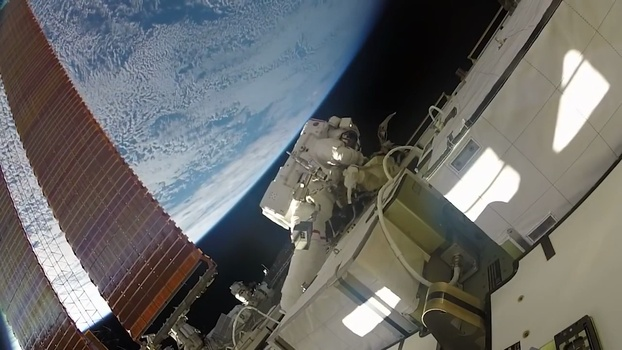

Video Path: ./shared_data/videos/video1/7Hcg-rLYwdM.mp4
Timestamp (ms): 16650.0
Transcript snippet: the science activities that happened over the last two months. The view is always amazing I didn't think I would do another spacewalk and to now have the chance to have done four more was just icing on the cake for a a wonderful mission.



In [29]:
retriever = vectorstore.as_retriever(
    search_type='similarity', 
    search_kwargs={"k": 1})
query2 = (
        "an astronaut's spacewalk "
        "with an amazing view of the earth from space behind"
)
results2 = retriever.invoke(query2)
display_retrieved_results(results2)

--- Document 1 ---


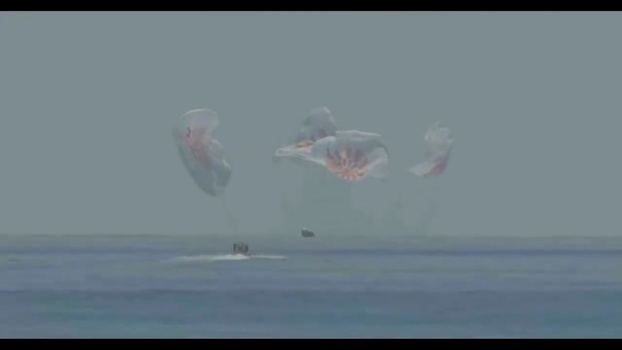

Video Path: ./shared_data/videos/video1/7Hcg-rLYwdM.mp4
Timestamp (ms): 73870.0
Transcript snippet: Splashdown! Welcome back to planet Earth and thanks for flying SpaceX. It's truly our honor and privilege. Space Dads are back on Earth after a 19-hour return journey from space.



In [30]:
query3 = "a group of astronauts"
results3 = retriever.invoke(query3)
display_retrieved_results(results3)

# Create Gradio interface

In [33]:
import gradio as gr
from PIL import Image
import os

# Define UI function combining retrieval and inference

def multimodal_qa_ui(query):
    # Retrieve segment metadata
    data = retrieve_video_segment_and_metadata(query)
    if not data:
        return None, "No relevant segment found."

    # Load and display frame
    frame_path = data.get("frame_path")
    frame = Image.open(frame_path) if frame_path and os.path.isfile(frame_path) else None

    # Build augmented prompt
    transcript = data.get("transcript") or ""
    augmented_query = f"The transcript associated with the image is '{transcript}'. {query}"

    # Run inference
    answer = run_lvml_inference(prompt=augmented_query, image_path=frame_path)

    return frame, answer

# Launch Gradio interface
def launch_ui():
    iface = gr.Interface(
        fn=multimodal_qa_ui,
        inputs=gr.Textbox(lines=1, placeholder="Enter your question..."),
        outputs=[
            gr.Image(type="pil", label="Retrieved Frame"),
            gr.Textbox(label="Answer")
        ],
        title="Multimodal Video QA"
    )
    iface.launch()

# Run the UI
if __name__ == "__main__":
    launch_ui()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
